In [55]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# Exploration Day20

In [33]:
D20_1 = sc.read_10x_mtx("../data/initial_10x_outputs/filtered_feature_bc_matrix-D20_1")

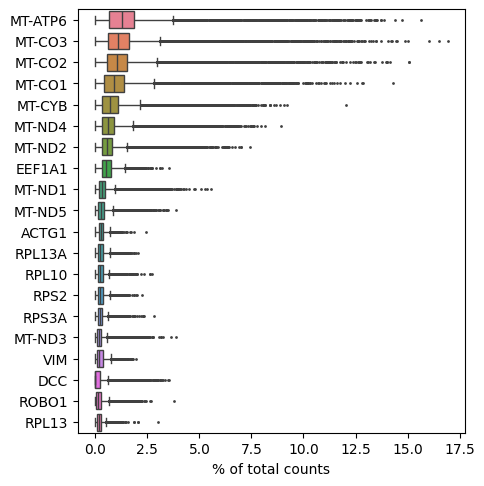

In [36]:
sc.pl.highest_expr_genes(D20_1, n_top=20)

#Basic filtering genes not expressed + cell with twoo few genes
sc.pp.filter_cells(D20_1, min_genes=200)
sc.pp.filter_genes(D20_1, min_cells=3)

## Distributions QC metrics for cells

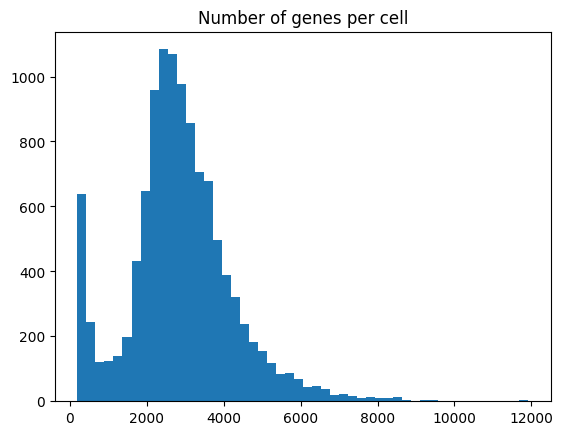

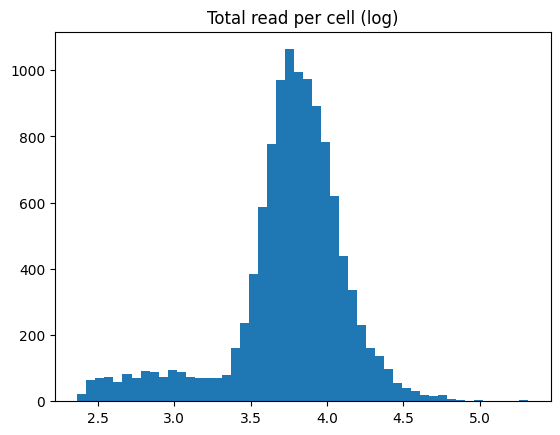

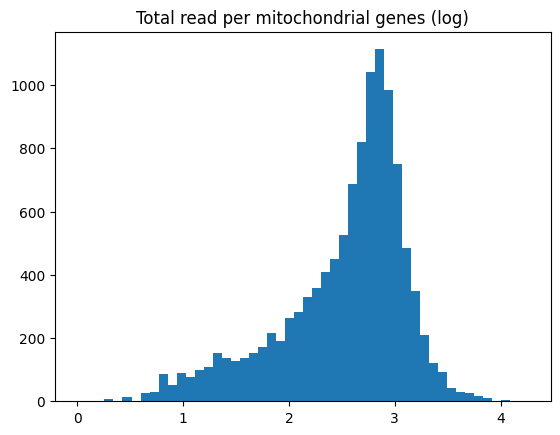

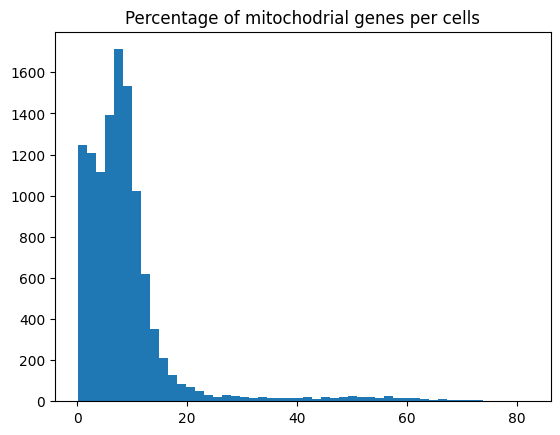

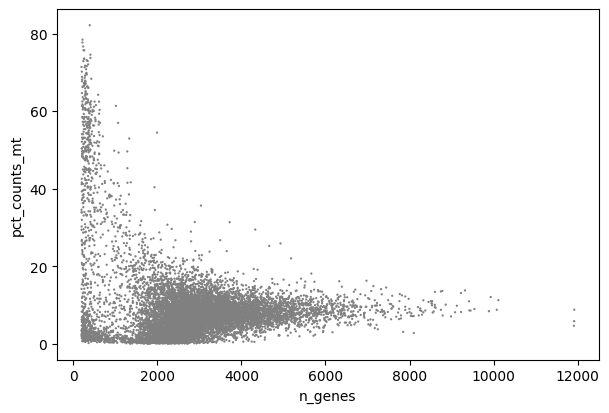

In [88]:
D20_1.var["mt"] = D20_1.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    D20_1, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

#Visualize distribution of cell metrics to define filtering thresholds
plt.hist(D20_1.obs.n_genes, bins=50)
plt.title("Number of genes per cell")
plt.show()

plt.hist(np.log10(D20_1.obs.total_counts), bins=50)
plt.title("Total read per cell (log)")
plt.show()

plt.hist(np.log10(D20_1.obs.total_counts_mt), bins=50)
plt.title("Total read per mitochondrial genes (log)")
plt.show()

plt.hist(D20_1.obs.pct_counts_mt, bins=50)
plt.title("Percentage of mitochodrial genes per cells")
plt.show()

sc.pl.scatter(D20_1, x="n_genes", y="pct_counts_mt")

## Distributions QC metrics for genes

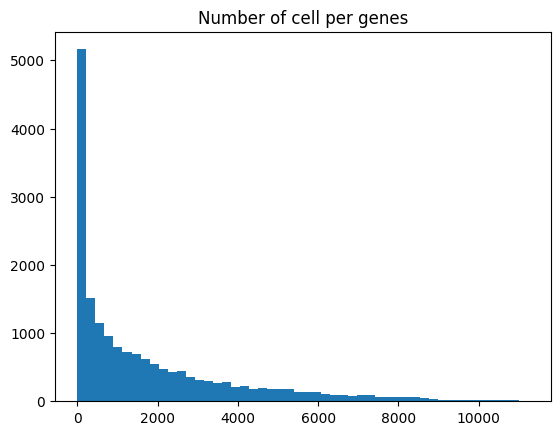

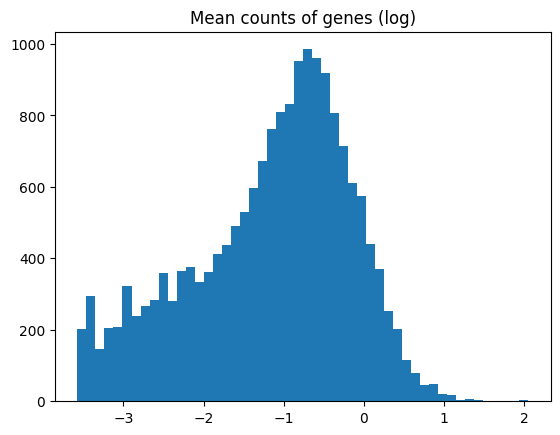

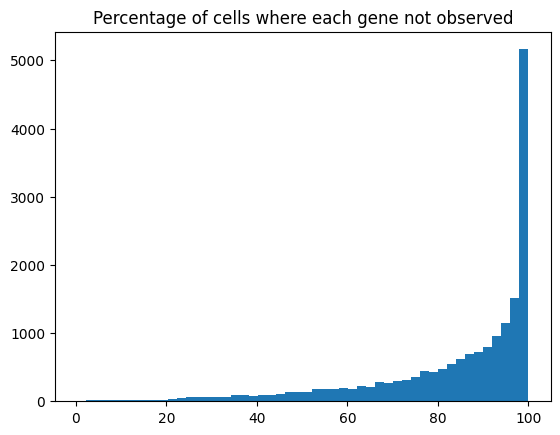

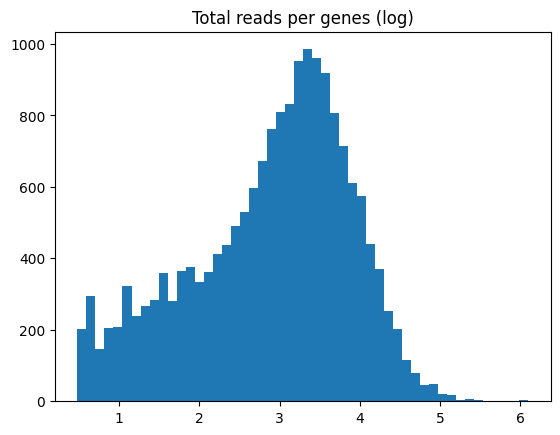

In [87]:
#Visualize distribution of genes metrics to define filtering thresholds
plt.hist(D20_1.var.n_cells, bins=50)
plt.title("Number of cell per genes")
plt.show()

plt.hist(np.log10(D20_1.var.mean_counts), bins=50)
plt.title("Mean counts of genes (log)")
plt.show()

plt.hist(D20_1.var.pct_dropout_by_counts, bins=50)
plt.title("Percentage of cells where each gene not observed")
plt.show()

plt.hist(np.log10(D20_1.var.total_counts), bins=50)
plt.title("Total reads per genes (log)")
plt.show()

## Filtering of cells

Remove the cell with extreme mitochondrial %.

Should we also remove the cells with very high number of genes?? (might be multiplets)

Same but low number of genes??? (might be droplets with ambient RNA)

**-> do rest of pipeline and come back to this point**

Check for doublets and empty droplets



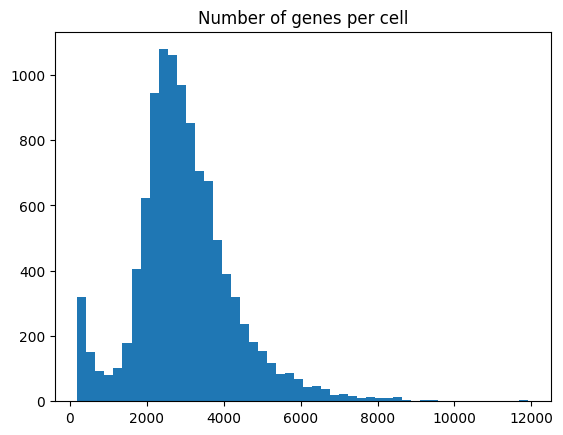

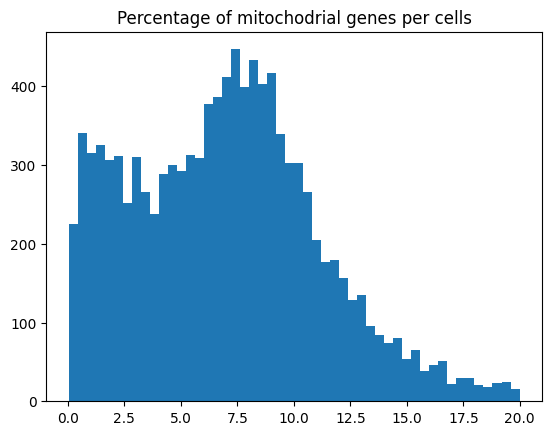

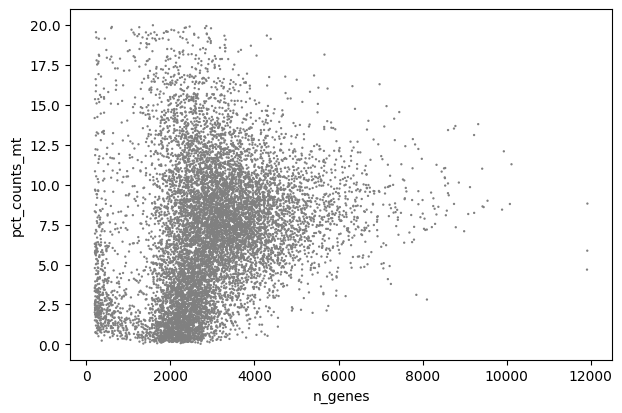

In [94]:
#Remove all cell with % mt > 20%
D20_1 = D20_1[D20_1.obs.pct_counts_mt < 20]

plt.hist(D20_1.obs.n_genes, bins=50)
plt.title("Number of genes per cell")
plt.show()

plt.hist(D20_1.obs.pct_counts_mt, bins=50)
plt.title("Percentage of mitochodrial genes per cells")
plt.show()

sc.pl.scatter(D20_1, x="n_genes", y="pct_counts_mt")

## Normalize the data

Each cell in scRNA-seq will have a differing number of reads associated with it. So to accurately compare expression between cells, it is necessary to normalize for sequencing depth.

In [95]:
sc.pp.normalize_per_cell(D20_1)
sc.pp.log1p(D20_1)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:523: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


## Identify the highly variables genes
Feature selection step, we keep only the highly variable genes to remove the noise in the data


In [101]:
D20_1.var.shape

(17919, 12)

In [108]:
sc.pp.highly_variable_genes(D20_1, min_mean=0.0125, max_mean=3, min_disp=0.5)
D20_1_HVG = D20_1[:, D20_1.var.highly_variable].copy()

#Scale each to unit variance 
sc.pp.scale(D20_1_HVG, max_value=10)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


## PCA 

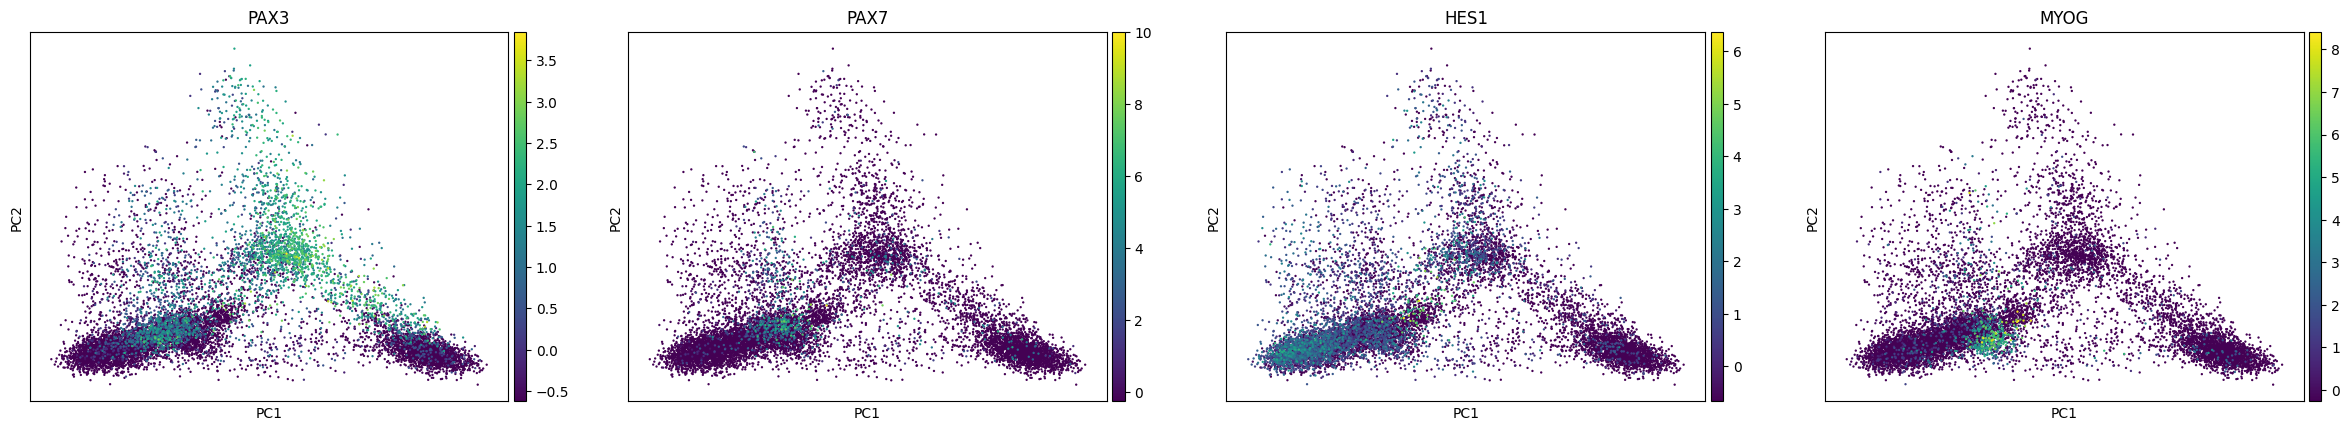

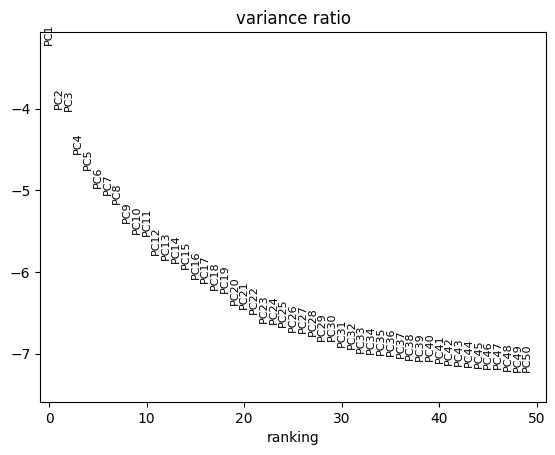

In [117]:
sc.tl.pca(D20_1_HVG, svd_solver="arpack")
sc.pl.pca(D20_1_HVG, color=["PAX3",'PAX7','HES1','MYOG']) # HEYL, MYOD1

#Variance to pick number of PCs
sc.pl.pca_variance_ratio(D20_1_HVG, log=True, n_pcs=50)

## Creating low dim space embedding


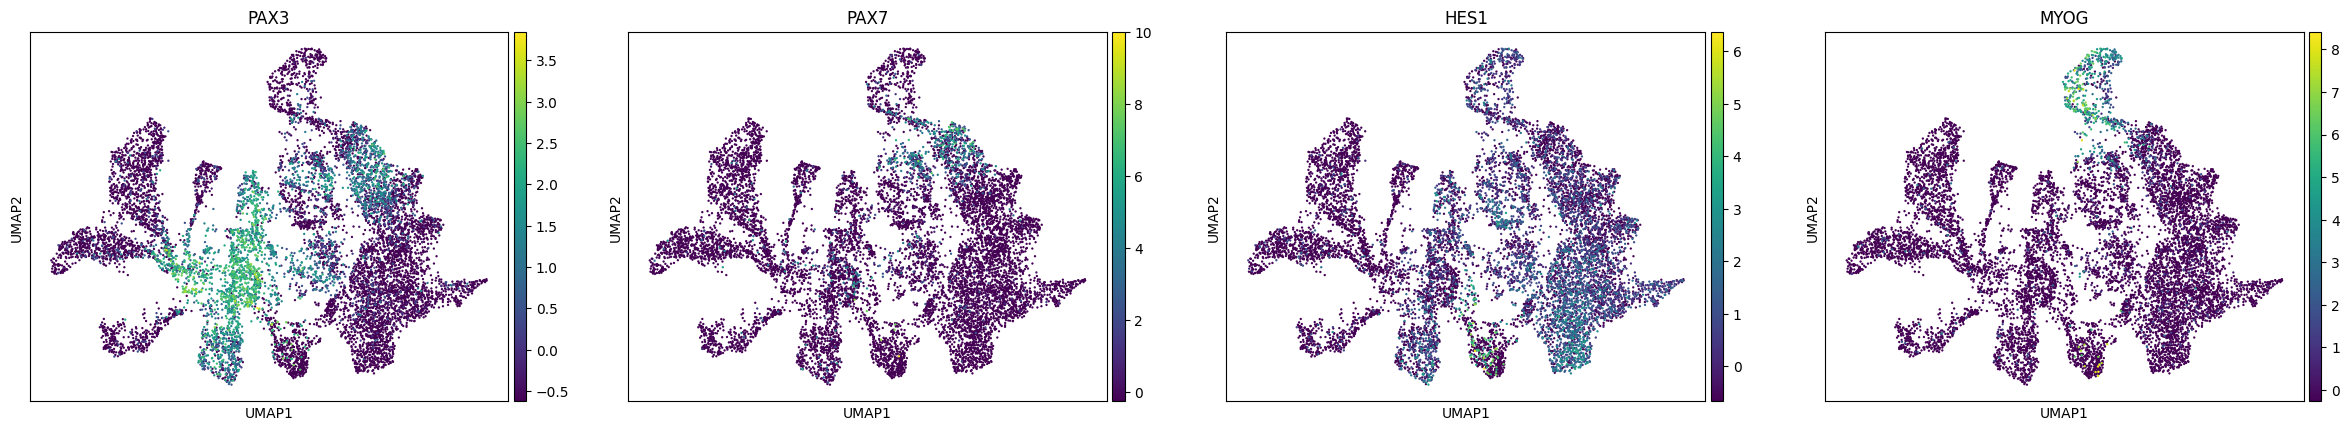

In [120]:
sc.pp.neighbors(D20_1_HVG, n_neighbors=10, n_pcs=30)

sc.tl.umap(D20_1_HVG)
sc.pl.umap(D20_1_HVG, color=["PAX3",'PAX7','HES1','MYOG'])

## Clustering cells

Resolution range: 0.1 - 4, play around with this parameter to see which one makes more sense

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/

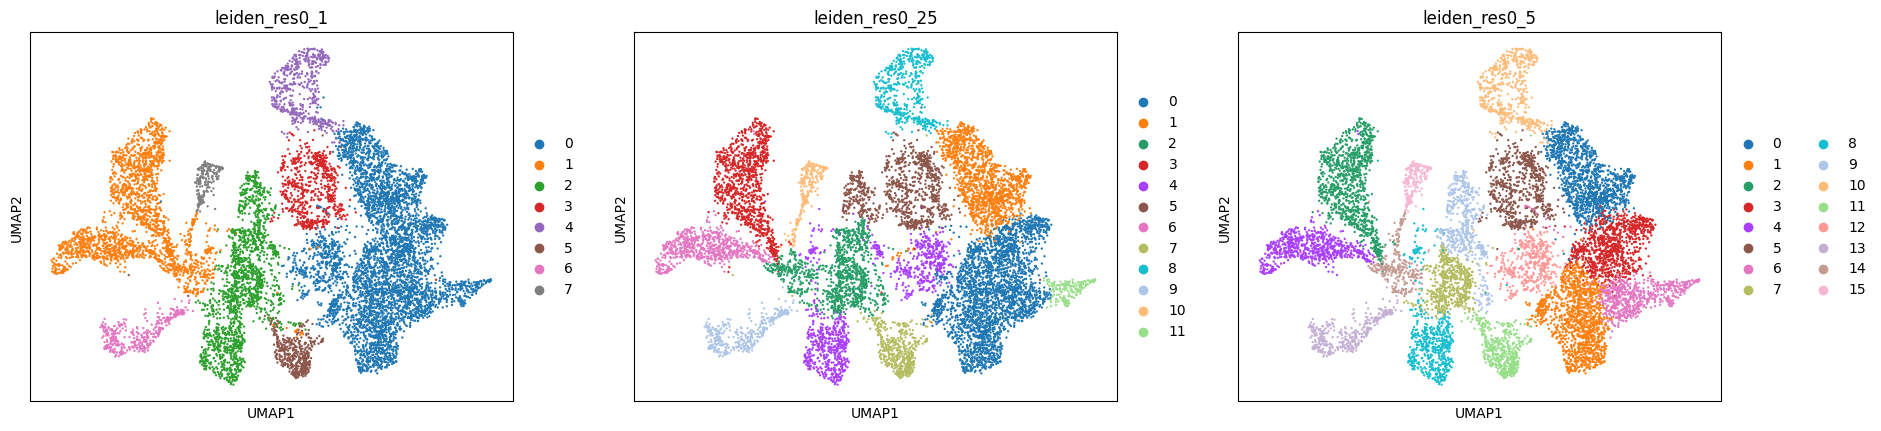

In [129]:
sc.tl.leiden(
    D20_1_HVG,
    resolution=0.1,
    random_state=0,
    key_added="leiden_res0_1"
)
sc.tl.leiden(
    D20_1_HVG,
    resolution=0.25,
    random_state=0,
    key_added="leiden_res0_25"
)
sc.tl.leiden(
    D20_1_HVG,
    resolution=0.5,
    random_state=0,
    key_added="leiden_res0_5"
)
sc.pl.umap(D20_1_HVG, color=["leiden_res0_1",'leiden_res0_25','leiden_res0_5'])

Find marker genes

/Users/adorman/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/tools/_rank_g

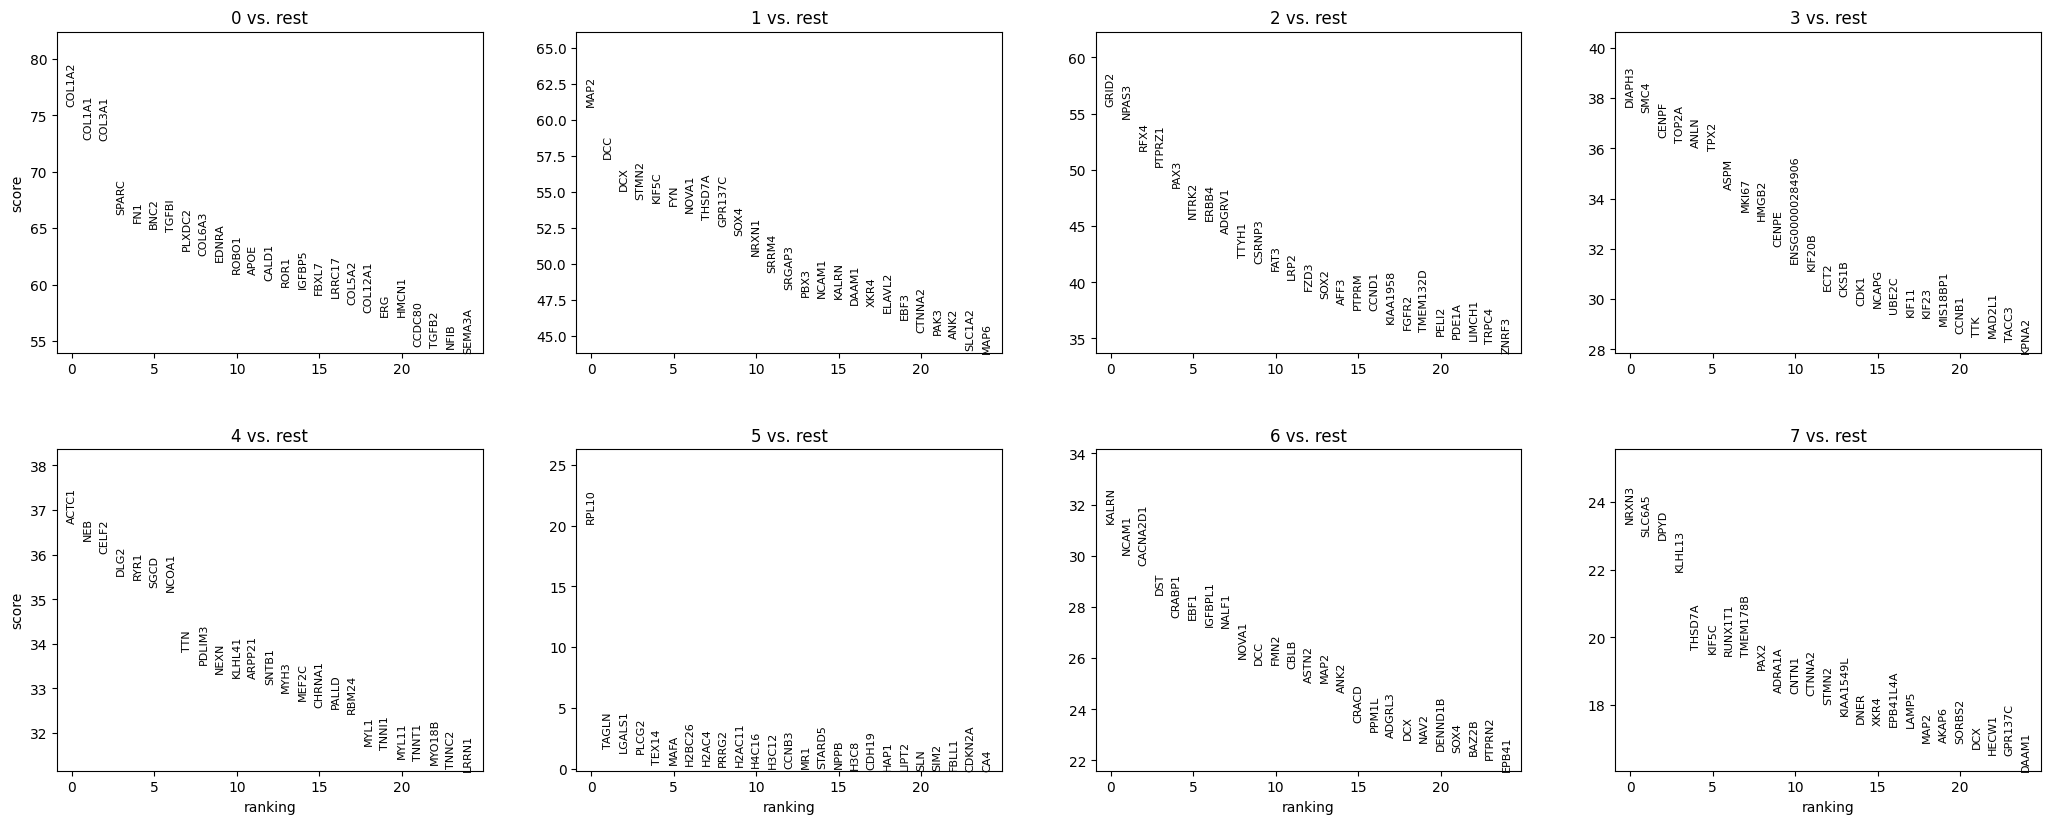

In [133]:
sc.tl.rank_genes_groups(D20_1_HVG, "leiden_res0_1", method="wilcoxon")
sc.pl.rank_genes_groups(D20_1_HVG, n_genes=25, sharey=False)